# Amazon Bedrock AgentCore Observability: Custom Span Creation

This notebook demonstrates how to create custom spans with OpenTelemetry for enhanced observability in Amazon Bedrock AgentCore. A span represents a discrete, measurable unit of work within an agent's execution flow. By creating custom spans, you can gain deeper insights into your agent's behavior and performance in the CloudWatch GenAI Observability dashboard.


## What you'll learn
- How to create custom spans with OpenTelemetry in your agent code
- How to add custom attributes and events to spans
- How to track errors and status in spans
- How to visualize custom spans in Amazon CloudWatch GenAI Observability


## Prerequisites
- Enable transaction search on Amazon CloudWatch. First-time users must enable CloudWatch Transaction Search to view Bedrock AgentCore spans and traces. To enable transaction search, please refer to the our [documentation](https://docs.aws.amazon.com/AmazonCloudWatch/latest/monitoring/Enable-TransactionSearch.html).
- Log group and Log stream configured on Amazon Cloudwatch to be added to the environment variables.
- AWS account with Amazon Bedrock Model access to Claude Haiku with Model ID: anthropic.claude-3-haiku-20240307-v1:0
- AWS credentials configured using `aws configure` 
- .env file updated with environment variables. An example is provided in `.env.example`

## 1. Setup and Installation

First, let's install the required dependencies. Please check that `aws-opentelemetry-distro` is in your requirements.txt file.

In [ ]:
#!pip install -r requirements.txt

## 2. Environment Configuration
To enable observability with custom spans for your agent and send telemetry data to Amazon CloudWatch, you'll need to configure the following environment variables. We use a `.env` file to manage these settings securely.

Create a `.env` file with your AWS credentials and configuration. Use `.env.example` as a template.

If you are using an existing `log group` and corresponding `log stream`, please add that to your environment variable. 

Else, you would need to **create** a log group and log stream in Cloudwatch before you set that as an environment variable, example names are provided.

Required Environment Variables:

| Variable | Value | Purpose |
|----------|-------|---------|
| `OTEL_PYTHON_DISTRO` | `aws_distro` | Use AWS Distro for OpenTelemetry (ADOT) |
| `OTEL_PYTHON_CONFIGURATOR` | `aws_configurator` | Set AWS configurator for ADOT SDK |
| `OTEL_EXPORTER_OTLP_PROTOCOL` | `http/protobuf` | Configure export protocol |
| `OTEL_EXPORTER_OTLP_LOGS_HEADERS` | `x-aws-log-group=<YOUR-LOG-GROUP>,x-aws-log-stream=<YOUR-LOG-STREAM>,x-aws-metric-namespace=<YOUR-NAMESPACE>` | Direct logs to CloudWatch groups |
| `OTEL_RESOURCE_ATTRIBUTES` | `service.name=<YOUR-AGENT-NAME>` | Identify your agent in observability data |
| `AGENT_OBSERVABILITY_ENABLED` | `true` | Activate ADOT pipeline |
| `AWS_REGION` | `<YOUR-REGION>` | AWS Region |

## 3. Load Environment Variables

Let's load the environment variables from the `.env` file:

In [ ]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Display the OTEL-related environment variables
otel_vars = [
    "OTEL_PYTHON_DISTRO",
    "OTEL_PYTHON_CONFIGURATOR",
    "OTEL_EXPORTER_OTLP_PROTOCOL",
    "OTEL_EXPORTER_OTLP_LOGS_HEADERS",
    "OTEL_RESOURCE_ATTRIBUTES",
    "AGENT_OBSERVABILITY_ENABLED",
    "OTEL_TRACES_EXPORTER"
]

print("OpenTelemetry Configuration:")
for var in otel_vars:
    value = os.getenv(var)
    if value:
        print(f"{var}={value}")

## 4. Understanding Custom Spans in OpenTelemetry

Spans include the following essential attributes for agent observability:

- Operation name identifying the specific function or process being executed
- Timestamps marking the exact start and end times of the operation
- Parent-child relationships showing how operations nest within larger processes
- Tags and attributes providing contextual metadata about the operation
- Events marking significant occurrences within the span's lifetime
- Status information indicating success, failure, or other completion states
- Resource utilization metrics specific to the operation

Custom spans allow you to track specific operations or segments of your agent's execution flow. By creating custom spans, you can:

- **Track specific operations**: Create spans for important operations like tool calls, data processing, or decision points
- **Add custom attributes**: Enrich spans with business-specific metadata for filtering and analysis
- **Record events**: Mark important moments within a span's lifecycle
- **Track errors**: Capture and report errors with detailed context
- **Establish relationships**: Create parent-child relationships between spans to model execution flow

This gives you much more granular control over what appears in your CloudWatch GenAI Observability dashboard.

## 5. Creating a Custom Span Agent

Let's examine a Strands agent implementation that uses custom spans to track its operations. The code below creates a travel agent with custom spans for the web search tool and the main agent execution.

In [ ]:
%%writefile custom_span_agent.py
import os
import logging
import sys
import argparse
from opentelemetry import baggage, context
from opentelemetry import trace

def parse_arguments():
    parser = argparse.ArgumentParser(description='Agent with Custom Span Creation')
    parser.add_argument('--session-id', 
                       type=str, 
                       required=True,
                       help='Session ID to associate with this agent run')
    return parser.parse_args()

def set_session_context(session_id):
    """Set the session ID in OpenTelemetry baggage for trace correlation"""
    ctx = baggage.set_baggage("session.id", session_id)
    token = context.attach(ctx)
    logging.info(f"Session ID '{session_id}' attached to telemetry context")
    return token

###########################
#### Agent Code below: ####
###########################

from strands import Agent, tool
from strands.models import BedrockModel
from duckduckgo_search import DDGS

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Configure Strands logging
logging.getLogger("strands").setLevel(logging.INFO)

@tool
def web_search(query: str) -> str:
    """Search the web for current information about travel destinations, attractions, and events."""
    # Get the tracer - use the service name for better trace organization
    tracer = trace.get_tracer("web_search", "1.0.0")
    
    # Start a new span for the web search operation
    with tracer.start_as_current_span("custom span web search tool") as span:
        try:
            # Add query attribute
            span.set_attribute("search.query", query)
            span.set_attribute("tool.name", "web_search")
            span.set_attribute("search.provider", "duckduckgo")
            
            # Add event for search start
            span.add_event("search_started", {"query": query})
            
            ddgs = DDGS()
            results = ddgs.text(query, max_results=5)
            
            # Add results count attribute
            span.set_attribute("search.results_count", len(results))
            
            formatted_results = []
            for i, result in enumerate(results, 1):
                formatted_result = (
                    f"{i}. {result.get('title', 'No title')}\n"
                    f"   {result.get('body', 'No summary')}\n"
                    f"   Source: {result.get('href', 'No URL')}\n"
                )
                formatted_results.append(formatted_result)
                
                # Add individual result attributes (limit to avoid too much data)
                if i <= 3:  # Only add details for first 3 results
                    span.set_attribute(f"search.result_{i}.title", result.get('title', 'No title')[:100])
                    span.set_attribute(f"search.result_{i}.url", result.get('href', 'No URL'))
            
            # Add the formatted results as an attribute (truncated to avoid too much data)
            search_results_text = "\n".join(formatted_results) if formatted_results else "No results found."
            span.set_attribute("search.results_summary", search_results_text[:500])  # Truncate for telemetry
            
            # Add success event
            span.add_event("search_completed", {
                "results_count": len(results),
                "success": True
            })
            
            # Set span status to OK
            span.set_status(trace.Status(trace.StatusCode.OK))
            
            logger.info(f"Web search completed successfully for query: {query[:50]}...")
            return search_results_text
            
        except Exception as e:
            # Add error information
            span.set_attribute("search.error", str(e))
            span.set_attribute("search.error_type", type(e).__name__)
            
            # Add error event
            span.add_event("search_failed", {
                "error": str(e),
                "error_type": type(e).__name__
            })
            
            # Set span status to ERROR
            span.set_status(trace.Status(trace.StatusCode.ERROR, str(e)))
            
            logger.error(f"Web search failed: {str(e)}")
            return f"Search error: {str(e)}"

def get_bedrock_model():
    model_id = os.getenv("BEDROCK_MODEL_ID", "anthropic.claude-3-haiku-20240307-v1:0")
    region = os.getenv("AWS_DEFAULT_REGION", "us-west-2")
    
    try:
        bedrock_model = BedrockModel(
            model_id=model_id,
            region_name=region,
            temperature=0.7,
            max_tokens=512
        )
        logger.info(f"Successfully initialized Bedrock model: {model_id} in region: {region}")
        return bedrock_model
    except Exception as e:
        logger.error(f"Failed to initialize Bedrock model: {str(e)}")
        logger.error("Please ensure you have proper AWS credentials configured and access to the Bedrock model")
        raise

def main():
    # Parse command line arguments
    args = parse_arguments()
    
    # Set session context for telemetry
    context_token = set_session_context(args.session_id)
    
    # Get tracer for main application
    tracer = trace.get_tracer("strands_travel_agent", "1.0.0")
    
    with tracer.start_as_current_span("travel_agent_session") as main_span:
        try:
            # Add session attributes to main span
            main_span.set_attribute("session.id", args.session_id)
            main_span.set_attribute("agent.type", "travel_agent")
            
            # Initialize Bedrock model
            bedrock_model = get_bedrock_model()

            # Create travel agent
            travel_agent = Agent(
                model=bedrock_model,
                system_prompt="""You are an expert web search agent specializing in finding accurate and relevant information
                                 with access to real-time web data. Your role is to efficiently search, analyze, and synthesize
                                 information from multiple sources to answer user queries comprehensively. You should provide
                                 well-researched responses with current information, clear summaries, and cite reliable sources
                                 when presenting your findings.""",
                tools=[web_search],
                trace_attributes={
                    "user.id": "user@domain.com",
                    "tags": ["Strands", "Observability"],
                }
            )

            # Execute the travel research task
            query = """Which of these restaurant are vegetarian friendly?"""

            main_span.add_event("agent_query_started", {"query": query[:100]})
            
            result = travel_agent(query)
            
            main_span.add_event("agent_query_completed", {"success": True})
            main_span.set_status(trace.Status(trace.StatusCode.OK))
            
            print("Result:", result)
            
        except Exception as e:
            main_span.set_attribute("error", str(e))
            main_span.set_status(trace.Status(trace.StatusCode.ERROR, str(e)))
            logger.error(f"Main execution failed: {str(e)}")
            raise
        finally:
            # Detach context when done
            context.detach(context_token)
            logger.info(f"Session context for '{args.session_id}' detached")

if __name__ == "__main__":
    main()

## 6. Key Components of Custom Spans

Let's break down the key components of custom span creation in the code above:

### 6.1 Creating a Tracer

```python
tracer = trace.get_tracer("web_search", "1.0.0")
```

The tracer is responsible for creating spans. You provide a name (typically your service or component name) and version.

### 6.2 Starting a Span

```python
with tracer.start_as_current_span("custom span web search tool") as span:
    # Span operations here
```

This creates a new span and makes it the current active span. The span name should be descriptive of the operation being performed.

### 6.3 Adding Attributes

```python
span.set_attribute("search.query", query)
span.set_attribute("tool.name", "web_search")
```

Attributes are key-value pairs that provide context about the span. They can be used for filtering and analysis in CloudWatch.

### 6.4 Recording Events

```python
span.add_event("search_started", {"query": query})
```

Events mark important moments within a span's lifecycle. They can include additional attributes.

### 6.5 Setting Status

```python
span.set_status(trace.Status(trace.StatusCode.OK))
# Or for errors:
span.set_status(trace.Status(trace.StatusCode.ERROR, str(e)))
```

Status indicates whether the operation was successful or encountered an error.

## 7. Running the Agent with Custom Spans

To run the agent with custom spans, use the `opentelemetry-instrument` command:

In [ ]:
!opentelemetry-instrument python custom_span_agent.py --session-id "custom-span-demo-1"

## 8. Viewing Custom Spans in CloudWatch

After running your agent with custom spans, you can view the traces in the CloudWatch GenAI Observability dashboard:

1. Open the AWS CloudWatch console
2. Navigate to **GenAI Observability** --> Bedrock AgentCore
3. Filter for your service name (set in `OTEL_RESOURCE_ATTRIBUTES`)
4. Click on a trace to view the detailed span hierarchy

In the trace view, you'll see:
- Your custom spans with their names
- The span hierarchy showing parent-child relationships
- Custom attributes you added to each span
- Events recorded within spans
- Error information for failed operations


#### Trace View Page:
Trace View:


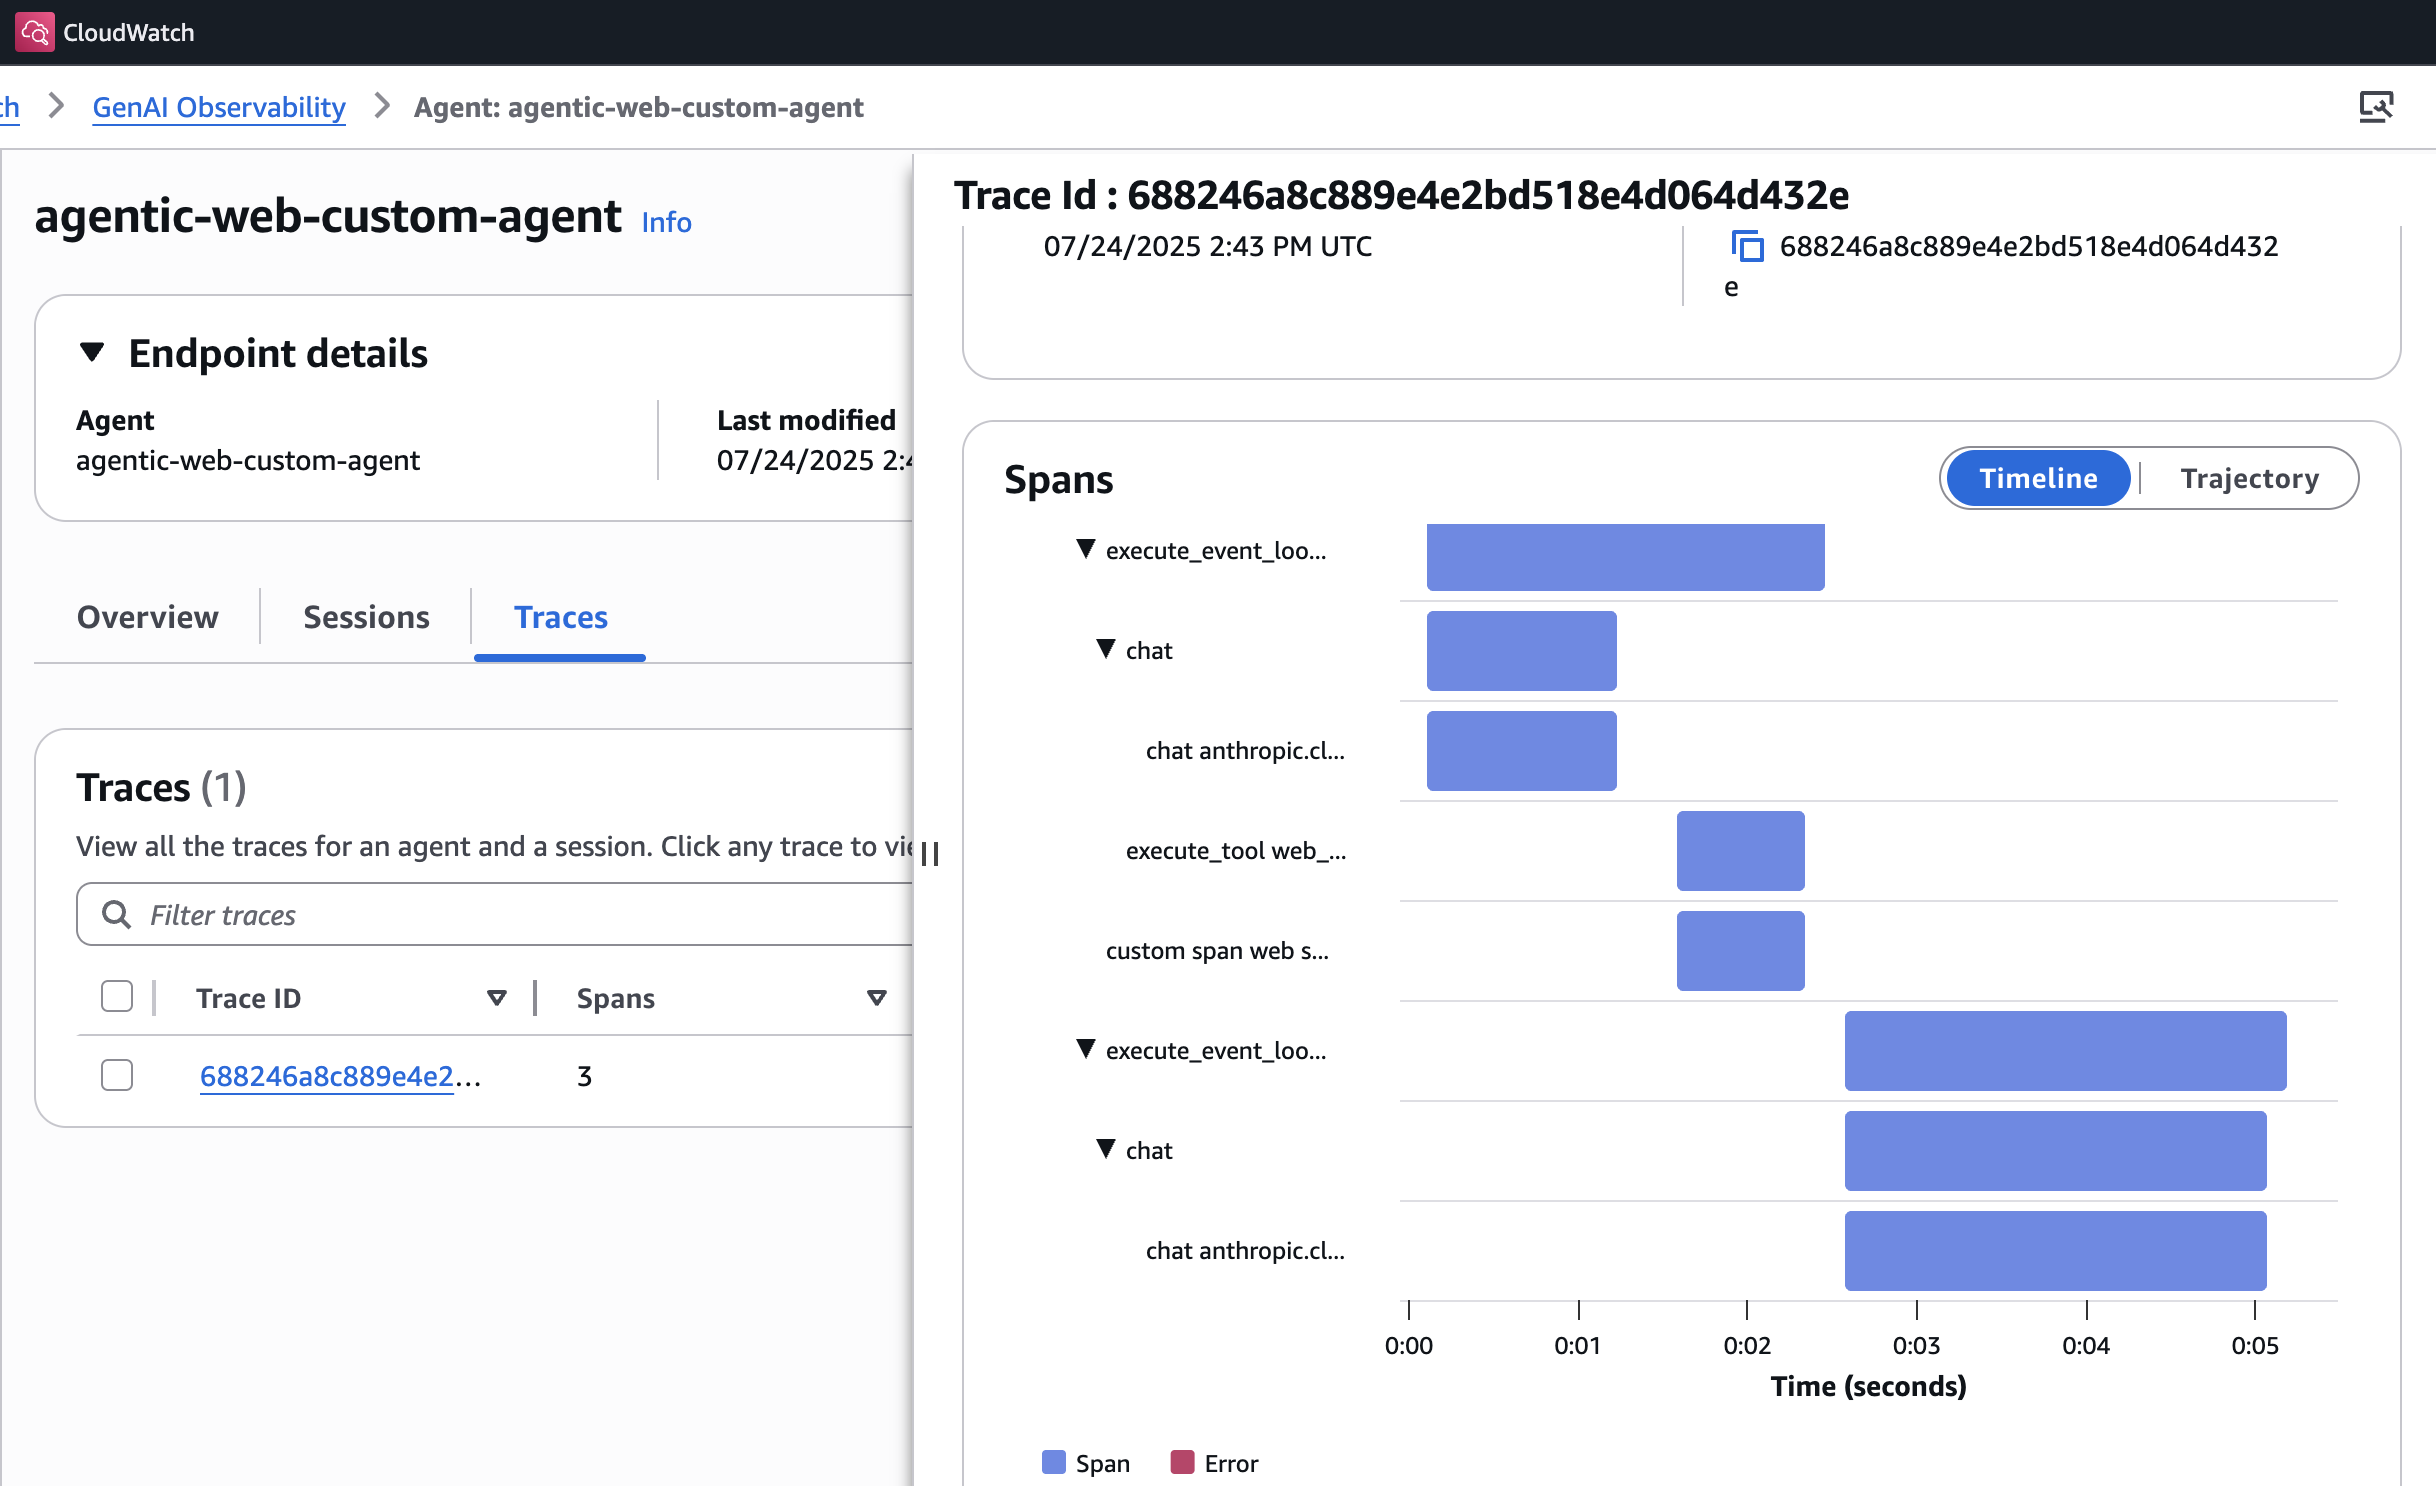



You can see the custom span attributes set in this notebook sample within the span information as shown below : 


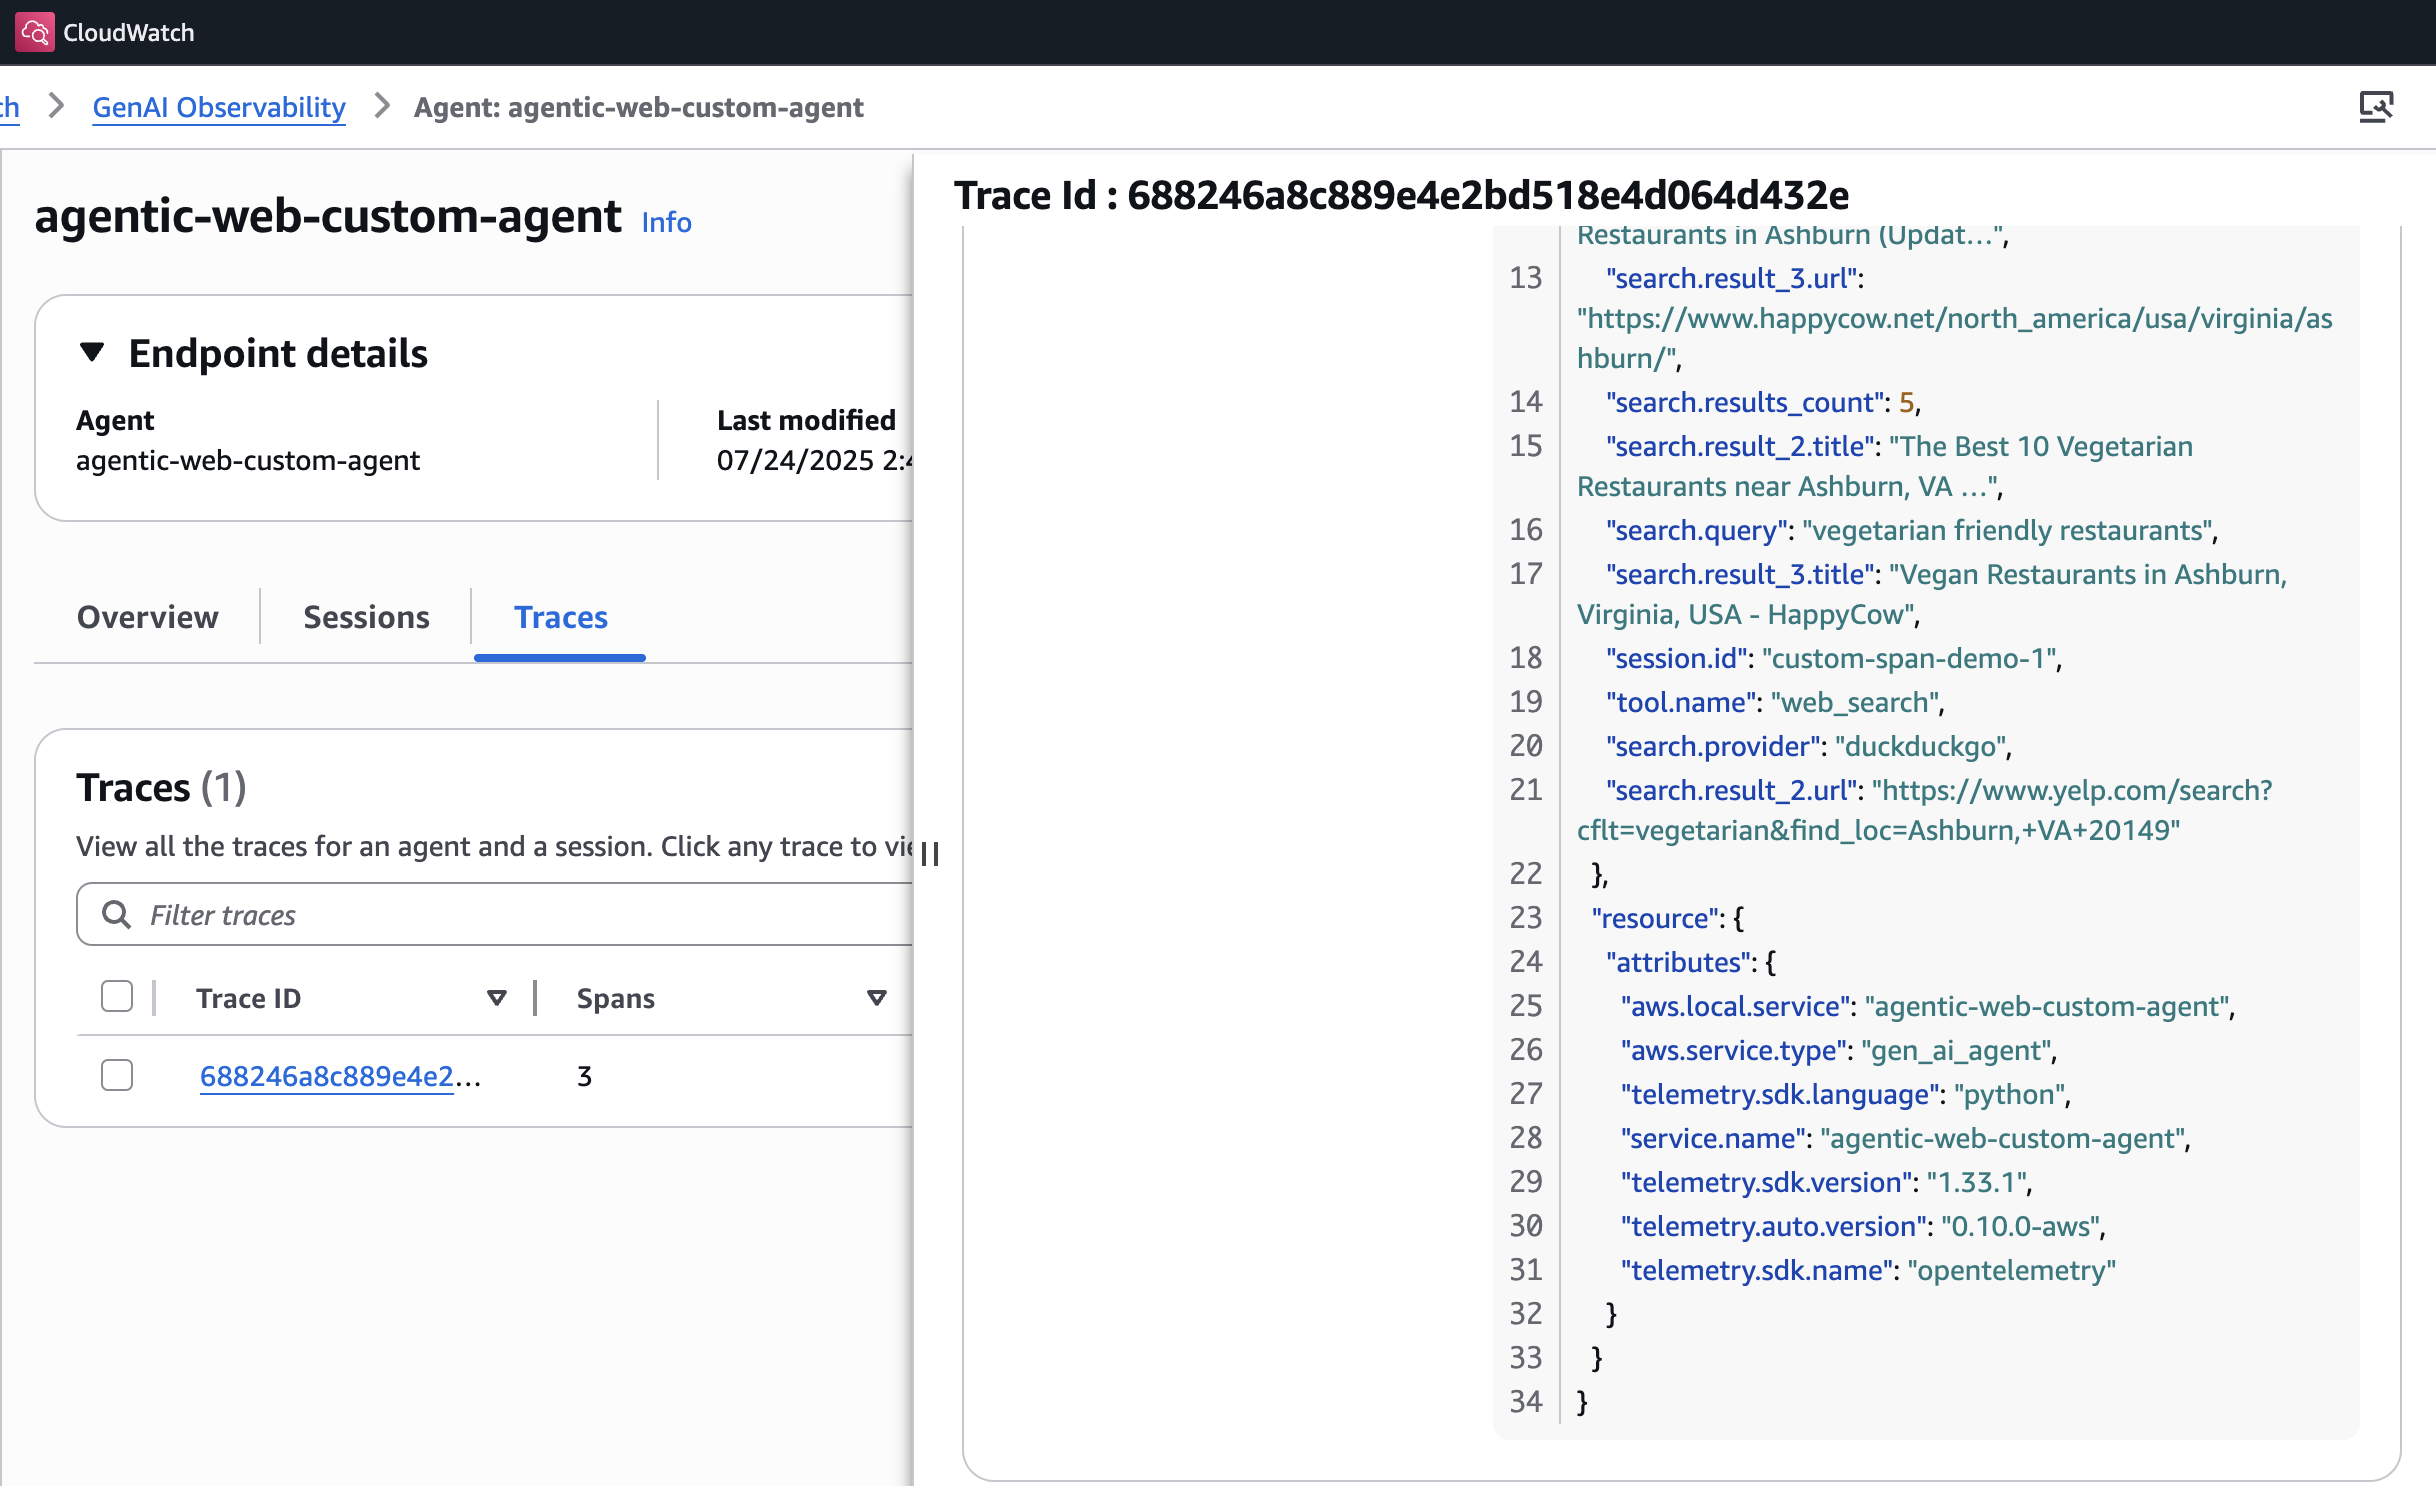

This detailed view helps you understand your agent's behavior, identify bottlenecks, and troubleshoot issues.



## 9. Best Practices for Custom Spans

When creating custom spans for your agents, follow these best practices:


1. **Create a logical span hierarchy**: Structure spans to reflect the logical flow of operations
2. **Add  attributes**: Include [GenAI Semantic conventions](https://opentelemetry.io/docs/specs/semconv/gen-ai/) in attributes, when possible that help with filtering and analysis
3. **Be mindful of sensitive data**: Handle PII or secrets in span attributes diligently
4. **Record important events**: Use events to mark significant moments in a span's lifecycle
5. **Set appropriate status**: Always set the span status to indicate success or failure
6. **Limit attribute size**: Keep attribute values concise to avoid overwhelming your telemetry system
7. **Close spans properly**: Always ensure spans are closed, preferably using context managers
8. **Add error details**: When errors occur, include error type and message in the span

## 10. Conclusion

Custom spans provide a powerful way to enhance the observability of your Amazon Bedrock AgentCore applications. By creating custom spans with rich context, you can gain deeper insights into your agent's behavior, performance, and decision-making process.

With the techniques demonstrated in this notebook, you can:

- Track specific operations within your agent's execution flow
- Add custom attributes for filtering and analysis
- Record important events during execution
- Capture detailed error information


These capabilities enable you to build more observable, debuggable, and reliable AI agents with Amazon Bedrock AgentCore Observability.